In [3]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf




Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,944 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 https://r2u.st

In [4]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("fatema").getOrCreate()

url = 'https://raw.githubusercontent.com/FatemaGirnary/Project_4/main/Resources/heart.csv'
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("heart.csv"), header=True)
df.show()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [5]:
# Get number of columns
num_cols = len(df.columns)

# Get number of rows
num_rows = df.count()

print(f"Number of columns: {num_cols}\nNumber of rows: {num_rows}")

Number of columns: 12
Number of rows: 918


In [6]:
from pyspark.sql.functions import count, col

# Group by all columns and count occurrences
duplicate_counts = df.groupBy(df.columns).count()

# Filter for rows with count > 1 to find duplicates
duplicates = duplicate_counts.filter(col("count") > 1)

# Count the number of duplicate rows
duplicate_count = duplicates.count()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [7]:

# Drop rows with any null values
df = df.dropna()

# Count the number of rows after dropping null values
row_count_after_drop = df.count()

print(f"Number of rows after dropping null values: {row_count_after_drop}")


Number of rows after dropping null values: 918


In [8]:
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [9]:
p_df = df.toPandas()
p_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0,Up,0


In [10]:
# Determine the number of unique values in each column.
unique_counts = p_df.nunique()
# Display the number of unique values for each column
print(unique_counts)

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


In [11]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_p_df = pd.get_dummies(p_df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
numeric_p_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,False,True,False,...,False,True,False,True,False,True,False,False,True,False
914,68,144,193,1,141,3.4,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
915,57,130,131,0,115,1.2,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
916,57,130,236,0,174,0,1,True,False,False,...,False,False,True,False,False,True,False,False,True,False


In [12]:
# Split our preprocessed data into our features and target arrays
target = numeric_p_df['HeartDisease']
features = numeric_p_df.drop(columns=['HeartDisease'])
X = features.values  # Features array
y = target.values    # Target array
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

number_input_features = X_train.shape[1]
print(f"Number of input features: {number_input_features}")

Number of input features: 20


In [13]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Create a Logistic Regression Model with the Original Data

###  Step 1: Fit a logistic regression model by using the training data (`X_train` and `y_train`).

In [14]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='liblinear', random_state=1, max_iter=200)
classifier

# Fit the model using training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

### Step 2: Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

In [15]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
225,1,1
226,1,1
227,0,0
228,1,1


### Step 3: Evaluate the model’s performance by doing the following:

* Generate a confusion matrix.

* Print the classification report.

In [16]:
# Generate a confusion matrix for the model
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 84,  13],
       [ 11, 122]])

In [17]:
# Print the classification report for the model
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        97
           1       0.90      0.92      0.91       133

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



**Question:** How well does the logistic regression model predict both the `0` (healthy heart) and `1` (diseased heart) labels?

**Answer:** The logistic regression model performs very well for the 'healthy heart' (0) with very good precision and high recall. The model also performs very well for the 'diseased heart'(1) with strong precision and recall. The high accuracy of 90% indicates that the model handles the data very well; however, there is a slight imbalance in performance between the 'healthy heart' and 'diseased heart'. The model is slightly less accurate in predicting healthy heart.

## Using other machine learning models

## Fitting the Decision Tree Model

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=1)

In [19]:
# Fit the model to the training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

## Making Predictions Using the Tree Model

In [20]:
# Make predictions on the test data
y_pred = dt_model.predict(X_test)

## Model Evaluation

In [21]:
# Generate a confusion matrix for the model
print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 84,  13],
       [ 11, 122]])

In [22]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.77      0.74        97
           1       0.82      0.76      0.79       133

    accuracy                           0.77       230
   macro avg       0.76      0.77      0.76       230
weighted avg       0.77      0.77      0.77       230



## Fitting the Random Forest Model

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)

In [24]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

## Making Predictions Using the Random Forest Model

In [25]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)

## Model Evaluation

In [26]:
# Generate a confusion matrix for the model
print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 83,  14],
       [ 11, 122]])

In [27]:
# Print the classification report
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        97
           1       0.90      0.92      0.91       133

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



## Feature Importance

In [28]:
# Random Forests in sklearn will automatically calculate feature importance
feature_names = ["Age", "Sex ", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.09645866221529548, 'FastingBS'),
 (0.09549843599532029, 'Cholesterol'),
 (0.09482885327718159, 'ChestPainType'),
 (0.07255260036371354, 'Age'),
 (0.07098828794578574, 'ExerciseAngina'),
 (0.06957417539979052, 'Sex '),
 (0.02538258148910927, 'Oldpeak'),
 (0.022498962323625183, 'RestingBP'),
 (0.0187854834452873, 'MaxHR'),
 (0.018423637756418133, 'RestingECG'),
 (0.011449018372373863, 'ST_Slope')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

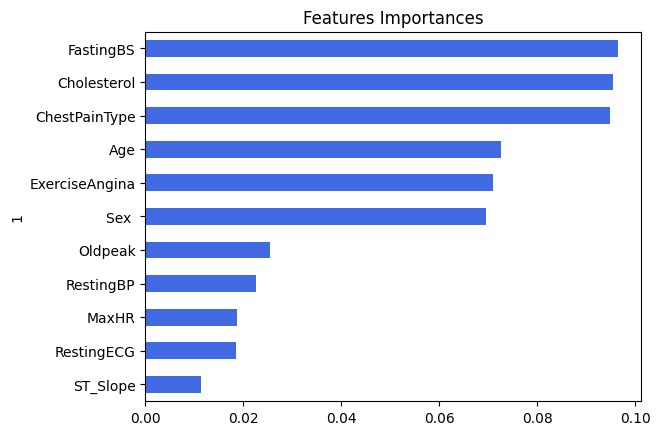

In [29]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='royalblue', title= 'Features Importances', legend=False)

## Making Predictions Using XGBoost

In [30]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Convert y_train and y_test to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Initialize the model with some parameters - fine-tune for better performance:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [32]:
# Train the model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:39:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [33]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        97
           1       0.91      0.93      0.92       133

    accuracy                           0.91       230
   macro avg       0.91      0.90      0.91       230
weighted avg       0.91      0.91      0.91       230



## Drop some features from the logistics regression model to improve accuracy

In [34]:
# Drop the ID columns, 'ST_Slope', "RestingECG" and 'MaxHR'.
important_df = p_df.drop(["ST_Slope","RestingECG", "MaxHR"], axis=1)

In [35]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_p_df = pd.get_dummies(important_df, columns=['Sex', 'ChestPainType','ExerciseAngina'])
numeric_p_df

,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,0,0,False,True,False,True,False,False,True,False
1,49,160,180,0,1,1,True,False,False,False,True,False,True,False
2,37,130,283,0,0,0,False,True,False,True,False,False,True,False
3,48,138,214,0,1.5,1,True,False,True,False,False,False,False,True
4,54,150,195,0,0,0,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,1.2,1,False,True,False,False,False,True,True,False
914,68,144,193,1,3.4,1,False,True,True,False,False,False,True,False
915,57,130,131,0,1.2,1,False,True,True,False,False,False,False,True
916,57,130,236,0,0,1,True,False,False,True,False,False,True,False


In [36]:
# Split our preprocessed data into our features and target arrays
target = numeric_p_df['HeartDisease']
features = numeric_p_df.drop(columns=['HeartDisease'])
X = features.values  # Features array
y = target.values    # Target array
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

number_input_features = X_train.shape[1]
print(f"Number of input features: {number_input_features}")

Number of input features: 13


In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='liblinear', random_state=1, max_iter=200)
classifier

# Fit the model using training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

In [38]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
225,1,1
226,1,1
227,1,0
228,1,1


In [39]:
# Generate a confusion matrix for the model
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 80,  17],
       [ 16, 117]])

In [40]:
# Print the classification report for the model
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        97
           1       0.87      0.88      0.88       133

    accuracy                           0.86       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



In [41]:
# Display data in table
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [226]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[1])
hidden_nodes_layer1 = 128
hidden_nodes_layer2 = 96
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
hidden_nodes_layer5 = 16

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='sigmoid'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='sigmoid'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation='sigmoid'))

# Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation='sigmoid'))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_205 (Dense)                    │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ (None, 96)                  │          12,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_208 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_210 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,905 (93.38 KB)

 Trainable params: 23,905 (93.38 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
# Compile the model
nn.compile(loss = 'huber', optimizer = 'adam', metrics = ['accuracy'])

In [228]:
# Ensure y_train is numeric
y_train = y_train.astype(float) # If y_train contains strings, converts it to float

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, validation_split= 0.15, epochs= 100, batch_size=50)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4628 - loss: 0.1509 - val_accuracy: 0.4904 - val_loss: 0.1400
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5355 - loss: 0.1308 - val_accuracy: 0.4904 - val_loss: 0.1246
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5759 - loss: 0.1211 - val_accuracy: 0.4904 - val_loss: 0.1226
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5657 - loss: 0.1197 - val_accuracy: 0.4904 - val_loss: 0.1206
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5717 - loss: 0.1163 - val_accuracy: 0.6442 - val_loss: 0.1131
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7058 - loss: 0.1108 - val_accuracy: 0.7404 - val_loss: 0.1004
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7608 - loss: 0.0940 - val_accuracy: 0.8365 - val_loss: 0.0753
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8349 - loss: 0.0732 - val_accuracy: 0.8462 

In [229]:
# Ensure y_test is numeric
y_test = y_test.astype(float)  # If y_test contains strings, converts it to float

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - 4ms/step - accuracy: 0.8957 - loss: 0.0447
Loss: 0.04474083334207535, Accuracy: 0.895652174949646
